# NYC Taxi Trips

## Time-series predictions

Here we are going to look into the data of many NYC taxi trips. Our intention is to analyze and to perform feature engineering in order to predict future taxi trip durations. 

# Setup

Run these cells to install all the packages you need to go through the analysis. Also, an auxiliary package called "utils.py" will be needed to help us in the data treatment (included). This may take a few minutes, so please be patient.

In [ ]:
!pip install -r requirements.txt

### Import

Import the required tools into the notebook.

In [3]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)

print('Import successful!')

Import successful!


In [4]:
%matplotlib inline

In [4]:
assert ft.__version__ == '0.1.19', 'Make sure you run the command above with the correct version.'

# Data

Loading the NYC taxi trip data. Note that this may take a minute or two, so please be patient.

In [5]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I
5,514035,1,2016-04-02 00:01:00,2016-04-02 00:09:00,2,1.50,-73.981956,40.765518,-73.968124,40.753407,1,458,AR,N
6,514036,1,2016-04-02 00:01:00,2016-04-02 00:05:00,1,1.50,-73.980019,40.780594,-73.968132,40.799595,2,213,AV,U
7,514037,1,2016-04-02 00:01:00,2016-04-02 00:20:00,1,4.20,-73.990501,40.756561,-73.986008,40.719414,2,1142,AA,AC
8,514038,1,2016-04-02 00:01:00,2016-04-02 00:10:00,1,0.60,-73.986198,40.730492,-73.991798,40.722240,1,501,AT,AC
9,514039,1,2016-04-02 00:01:00,2016-04-02 00:17:00,1,0.60,-73.990959,40.734890,-74.001816,40.739319,1,954,R,Q


We can also plot some aspects of the data to get a better sense of its distributions. For instance, here is the `trip_duration` variable we are going to try to predict.

## Histogram visualization of trip duration

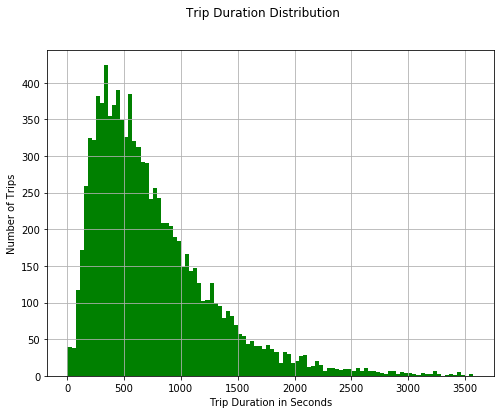

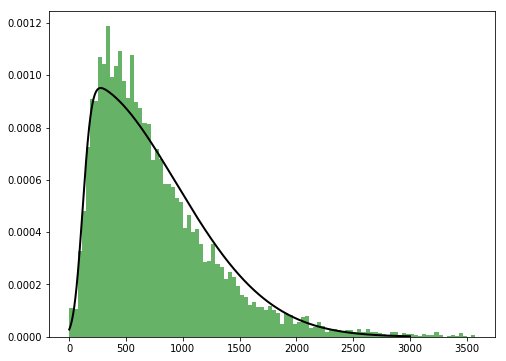

In [30]:
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(8,6))
trips.trip_duration.hist(bins = 100, color = 'g')
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Duration Distribution')

# setting some parameters to skewnorm fit (m = mean, s = std, loc = skew)
m, s, loc = stats.skewnorm.fit(trips['trip_duration'])
lnspc = np.linspace(0, 3000, len(trips['trip_duration'])) # range of data in x
pdf_g = stats.skewnorm.pdf(lnspc, m, s, loc) # now get theoretical values in our interval

# Plot the PDF.
plt.figure(figsize=(8,6))
plt.hist(trips['trip_duration'], bins=100, density=True, alpha=0.6, color='g')
plt.plot(lnspc, pdf_g, 'k', linewidth=2)

In [7]:
trips.shape[0]  # Tells us how many trips are in the dataset

10000

In [9]:
avgs = [trips.trip_duration.mean(), trips.trip_duration.std()]
avgs

[746.0989, 525.0494961583445]

The dataset presents a form of left skewed distribution, where we have the data of 10.000 trips. The average of trip duration is around 746 seconds (~ 12, 4 minutes) with a standard deviation of 525 seconds (8,75 minutes).

# Entities and Relationships

Gather the information needed to be provided when using the feature tools 

In [6]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entities and relationships successful!')

Entities and relationships successful!


# Transform Primitives

In [7]:
trans_primitives = [Weekend]

# This may take some time to compute
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

print('Transform primitives successful!')

Transform primitives successful!


Here are the features that we just created. Note: This list may contain the `trip_duration` variable. But, rest assured that we will not actually use this variable in training. Our code removes that variable in `utils.py`.

In [8]:
print(f"Number of features: {len(features)}")
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Finally, we compute the feature matrix from these features.

In [9]:
import pandas as pd
z = trips[['id', 'pickup_datetime']]
z['pickup_datetime'] = pd.to_numeric(z.pickup_datetime)

feature_matrix = compute_features(features, z)
preview(feature_matrix, 20)

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,trip_distance,trip_duration,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,...,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,pickup_neighborhoods.latitude,IS_WEEKEND(pickup_datetime),dropoff_neighborhoods.latitude,vendor_id
id,,,,,,,,,,,,,,,,,,,,,
514030,2.46,1039,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.757707,True,40.766809,2
514031,7.90,1454,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.744928,True,40.793597,1
514032,1.00,1168,True,0,0,0,0,0,0,0,...,0,0,0,0,0,1,40.729652,True,40.740333,1
514033,0.02,35,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.720245,True,40.720245,2
514034,19.00,3470,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.646194,True,40.785005,1
514035,1.50,458,True,0,0,0,0,0,0,0,...,0,0,0,1,0,0,40.766488,True,40.756598,1
514036,1.50,213,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.776270,True,40.793597,1
514037,4.20,1142,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.757707,True,40.720245,1
514038,0.60,501,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.729670,True,40.720245,1


# First Model

Preparing the data to train our first model with the entities and primitives designed above

In [10]:
# Split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.72s
         2           0.4148            1.90s
         3           0.3661            1.94s
         4           0.3266            1.94s
         5           0.2934            2.34s
         6           0.2665            2.28s
         7           0.2441            2.21s
         8           0.2257            2.16s
         9           0.2103            2.02s
        10           0.1973            1.89s
        20           0.1434            1.74s
        30           0.1312            1.48s
        40           0.1248            1.15s
        50           0.1218            0.88s
        60           0.1191            0.64s
        70           0.1174            0.47s
        80           0.1158            0.31s
        90           0.1147            0.15s
       100           0.1137            0.00s
0.7527788676087426
Training successful!


In this model we have used 13 features without aggregation primitives and including only weekend trips. With this, we gather all the information about the pickup and dropoff neighborhoods (id, longitude, latitude), payment method and trip duration. Our score (~ 0.75) is a bit poor and the performance of the model is better than  that without these features, however weekend trips maybe are not that significant due to the observed train loss.

# More Transform Primitives

Adding more primitives to see if we can have a better score

In [12]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

print('Transform primitives successful!')

Transform primitives successful!


In [13]:
print(f"Number of features: {len(features)}")
features

Number of features: 25


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [14]:
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AB,dropoff_neighborhood = AV,...,WEEK(pickup_datetime),trip_distance,MINUTE(pickup_datetime),HOUR(pickup_datetime),pickup_neighborhoods.latitude,payment_type,WEEKDAY(dropoff_datetime),passenger_count,WEEKDAY(pickup_datetime),DAY(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,True,0,0,0,0,0,0,0,0,0,...,13,2.46,0,0,40.757707,1,5,1,5,2
514031,True,0,0,0,0,0,0,0,0,0,...,13,7.90,0,0,40.744928,1,5,2,5,2
514032,True,0,0,0,0,0,0,0,0,0,...,13,1.00,0,0,40.729652,1,5,1,5,2
514033,True,0,0,0,0,0,0,0,0,0,...,13,0.02,0,0,40.720245,2,5,1,5,2
514034,True,0,0,0,0,0,0,0,0,0,...,13,19.00,1,0,40.646194,1,5,2,5,2


In [15]:
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            3.81s
         2           0.4148            3.70s
         3           0.3661            3.54s
         4           0.3264            3.08s
         5           0.2930            2.83s
         6           0.2660            2.78s
         7           0.2432            2.66s
         8           0.2245            2.66s
         9           0.2090            2.67s
        10           0.1960            2.57s
        20           0.1362            2.25s
        30           0.1200            1.93s
        40           0.1126            1.57s
        50           0.1079            1.23s
        60           0.1047            0.94s
        70           0.1016            0.68s
        80           0.0986            0.43s
        90           0.0938            0.21s
       100           0.0899            0.00s
0.8059573190397493
Training successful!


In this situation, the final score was improved by adding more primitives and now is around .81. The addition of more primitives gives us more detailed information about the trips. However, the training time is practically doubled when compared to the first model (1.72 vs 3.81). 

# Aggregation Primitives

In [17]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

print('Aggregation primitives successful!')

Aggregation primitives successful!


In [18]:
print(f"Number of features: {len(features)}")
features

Number of features: 75


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.SUM(trips.vendor_id)>,
 <Fe

In [19]:
# This may take a bit longer to compute, so please be patient
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,IS_WEEKEND(dropoff_datetime),pickup_neighborhoods.MEDIAN(trips.trip_duration),pickup_neighborhoods.STD(trips.trip_distance),MONTH(pickup_datetime),dropoff_neighborhoods.STD(trips.trip_duration),WEEK(dropoff_datetime),pickup_neighborhoods.longitude,pickup_neighborhoods.MIN(trips.passenger_count),HOUR(pickup_datetime),payment_type,...,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,vendor_id,pickup_neighborhoods.SUM(trips.vendor_id),DAY(dropoff_datetime),dropoff_neighborhoods.MAX(trips.trip_duration)
id,,,,,,,,,,,,,,,,,,,,,
514030,True,NaN,NaN,4,NaN,13,-73.986446,NaN,0,1,...,0,0,0,0,0,0,2,NaN,2,NaN
514031,True,NaN,NaN,4,NaN,13,-73.919159,NaN,0,1,...,0,0,0,0,0,0,1,NaN,2,NaN
514032,True,NaN,NaN,4,NaN,13,-73.991595,NaN,0,1,...,0,0,0,0,0,1,1,NaN,2,NaN
514033,True,NaN,NaN,4,NaN,13,-73.987205,NaN,0,2,...,0,0,0,0,0,0,2,NaN,2,NaN
514034,True,NaN,NaN,4,NaN,13,-73.785073,NaN,0,1,...,0,0,0,0,0,0,1,NaN,2,NaN


In [20]:
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Data split successful!


In [21]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            3.59s
         2           0.4148            3.36s
         3           0.3661            3.12s
         4           0.3264            8.76s
         5           0.2930            7.31s
         6           0.2660            6.24s
         7           0.2432            5.57s
         8           0.2245            5.07s
         9           0.2090            4.59s
        10           0.1960            4.20s
        20           0.1362            2.42s
        30           0.1200            1.86s
        40           0.1126            1.46s
        50           0.1079            1.12s
        60           0.1047            0.83s
        70           0.1016            0.57s
        80           0.0986            0.37s
        90           0.0938            0.18s
       100           0.0899            0.00s
0.8060128240391375
Training successful!


# Evaluate on Test Data

In [22]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # undo the log we took earlier

print('y_pred computation successful!')

y_pred computation successful!


In [23]:
# Print the first 5 predictions
y_pred[:5]

array([453.4415368 , 666.8066337 , 634.00494622, 617.34019506,
       407.96332751])

Histogram generation successful!


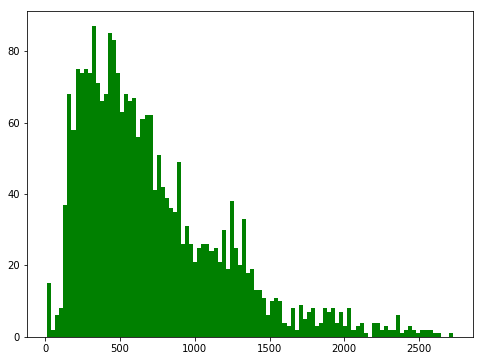

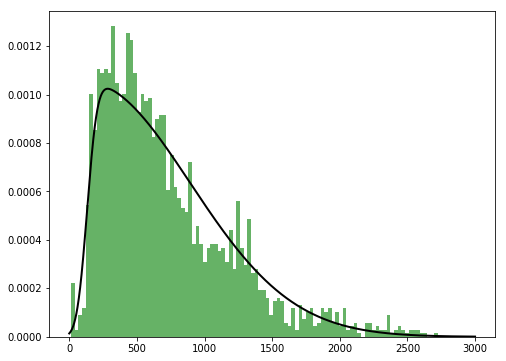

In [34]:
# Create a histogram of all of them
plt.figure(figsize=(8,6))
matplotlib.pyplot.hist(y_pred, bins = 100, color = 'g')

print('Histogram generation successful!')

# setting some parameters to skewnorm fit (m = mean, s = std, loc = skew)
m, s, loc = stats.skewnorm.fit(y_pred)
lnspc = np.linspace(0, 3000, len(y_pred)) # range of data in x
pdf_g = stats.skewnorm.pdf(lnspc, m, s, loc) # now get theoretical values in our interval

# Plot the PDF.
plt.figure(figsize=(8,6))
plt.hist(y_pred, bins=100, density=True, alpha=0.6, color='g')
plt.plot(lnspc, pdf_g, 'k', linewidth=2)

The predictions made are very close to the distribution of the real trips. Probably, if we have included the payment method this would have made our model even better.

# Feature Importance

In [28]:
feature_importances(model, feature_matrix.columns, n=25)

1: Feature: pickup_neighborhoods.MAX(trips.passenger_count), 0.861
2: Feature: HOUR(pickup_datetime), 0.035
3: Feature: dropoff_neighborhoods.STD(trips.trip_duration), 0.026
4: Feature: dropoff_neighborhoods.MEAN(trips.passenger_count), 0.026
5: Feature: payment_type, 0.014
6: Feature: pickup_neighborhoods.longitude, 0.010
7: Feature: MINUTE(dropoff_datetime), 0.008
8: Feature: MONTH(pickup_datetime), 0.007
9: Feature: dropoff_neighborhoods.MEDIAN(trips.vendor_id), 0.005
10: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.002
11: Feature: WEEK(dropoff_datetime), 0.001
12: Feature: pickup_neighborhoods.MIN(trips.trip_distance), 0.001
13: Feature: dropoff_neighborhoods.MEDIAN(trips.trip_distance), 0.001
14: Feature: dropoff_neighborhoods.MEAN(trips.trip_distance), 0.001
15: Feature: dropoff_neighborhoods.STD(trips.passenger_count), 0.000
16: Feature: IS_WEEKEND(pickup_datetime), 0.000
17: Feature: dropoff_neighborhood = AA, 0.000
18: Feature: pickup_neighborhoods.latitude, 0.00

As we can observe, the most important feature is the pickup neighborhood and the second most is the hour, which make total sense. What is surprising is the fact that either weekday or weekend feature seem to have no importance in this model.

<hr>